In [4]:
import json
import os
from datetime import datetime, timedelta
from typing import Any, Dict, Optional

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import mplfinance as mpf
import timm
import torch
from torch import nn
from torchvision import transforms

from dotenv import load_dotenv
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import now

In [ ]:
load_dotenv()
TOKEN = os.getenv("TINKOFF_TOKEN")
TICKER = "SBER"
TIMEFRAME = CandleInterval.CANDLE_INTERVAL_5_MIN
TZ = pytz.timezone("Europe/Moscow")
LOOKBACK = 60
DAYS = 7  # нужен день назад + текущий для окна CV
META_PATH = "meta.json"
CV_MODEL_PATH = "best_model.pth"

if not TOKEN:
    raise RuntimeError("❌ В .env не найден TINKOFF_TOKEN")

In [6]:
def fetch_tinkoff_candles(token: str, ticker: str, days: int = 1, interval=TIMEFRAME):
    with Client(token) as client:
        instruments: InstrumentsService = client.instruments
        shares = instruments.shares().instruments
        figi = None
        for share in shares:
            if share.ticker.upper() == ticker.upper():
                figi = share.figi
                break
        if not figi:
            raise RuntimeError(f"FIGI для {ticker} не найден")

        end = now()
        start = end - timedelta(days=days)
        candles = client.get_all_candles(
            figi=figi,
            from_=start,
            to=end,
            interval=interval,
        )

        data = []
        for candle in candles:
            data.append({
                "time": candle.time.astimezone(TZ),
                "open": candle.open.units + candle.open.nano / 1e9,
                "high": candle.high.units + candle.high.nano / 1e9,
                "low": candle.low.units + candle.low.nano / 1e9,
                "close": candle.close.units + candle.close.nano / 1e9,
                "volume": candle.volume,
            })
        df = pd.DataFrame(data)
        return df

print("🔑 Проверка токена и загрузка свежих данных из Tinkoff API…")
df_check = fetch_tinkoff_candles(TOKEN, TICKER, days=DAYS)
print(f"✅ {len(df_check)} свечей загружено")
display(df_check.tail())

🔑 Проверка токена и загрузка свежих данных из Tinkoff API…
✅ 6484 свечей загружено


,time,open,high,low,close,volume
6479,2025-11-25 09:50:00+03:00,306.18,306.19,306.00,306.18,51144
6480,2025-11-25 09:55:00+03:00,306.17,306.18,305.76,305.91,198181
6481,2025-11-25 10:00:00+03:00,305.92,306.19,305.71,305.92,121686
6482,2025-11-25 10:05:00+03:00,305.91,305.91,305.68,305.76,40290
6483,2025-11-25 10:10:00+03:00,305.76,305.79,305.71,305.77,42844


In [7]:
def add_cv_features(df: pd.DataFrame) -> pd.DataFrame:
    '''Compute technical indicators needed for candlestick chart rendering.'''
    df = df.copy()
    df["ema_10"] = df["close"].ewm(span=10).mean()
    df["ema_20"] = df["close"].ewm(span=20).mean()
    mid = df["close"].rolling(20).mean()
    std = df["close"].rolling(20).std()
    df["boll_up"] = mid + 2 * std
    df["boll_low"] = mid - 2 * std
    return df


def render_candle_image(
    sub_df: pd.DataFrame,
    img_size: tuple = (8, 4),
    dpi: int = 100,
    use_jpg: bool = True,
    style: Optional[Any] = None,
) -> np.ndarray:
    '''Render a single candlestick window into a NumPy RGB image.'''
    if mpf is None or plt is None:
        raise ImportError(
            "mplfinance and matplotlib must be installed to render candle images; "
            "install them via `pip install mplfinance matplotlib`"
        )
    if style is None:
        mc = mpf.make_marketcolors(
            up="lime", down="red", edge="white", wick="white", volume="gray"
        )
        style = mpf.make_mpf_style(
            base_mpf_style="nightclouds",
            facecolor="black",
            edgecolor="white",
            marketcolors=mc,
            rc={"axes.labelcolor": "white", "axes.edgecolor": "white"},
        )
    fig, axes = mpf.plot(
        sub_df,
        type="candle",
        style=style,
        volume=True,
        figsize=img_size,
        tight_layout=True,
        show_nontrading=True,
        returnfig=True,
    )
    for ax in axes:
        ax.set_axis_off()
        ax.grid(False)
    if "ema_10" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_10"], color="deepskyblue", linewidth=1)
    if "ema_20" in sub_df.columns:
        axes[0].plot(sub_df.index, sub_df["ema_20"], color="orange", linewidth=1)
    if {"boll_up", "boll_low"}.issubset(sub_df.columns):
        axes[0].plot(sub_df.index, sub_df["boll_up"], color="gray", linestyle="--", linewidth=0.8)
        axes[0].plot(sub_df.index, sub_df["boll_low"], color="gray", linestyle="--", linewidth=0.8)
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    w, h = fig.canvas.get_width_height()
    img = np.frombuffer(buf, dtype=np.uint8).reshape((h, w, 4))[..., :3]
    plt.close(fig)
    return img


def prepare_cv_tensor(img: np.ndarray) -> torch.Tensor:
    '''Convert an RGB image array into a Torch tensor with normalization.'''
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    return transform(img).unsqueeze(0)


In [8]:
from torchvision import transforms, models

def create_model(num_classes, device):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_feat = model.fc.in_features
    
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_feat, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.1),
        nn.Linear(512, num_classes)
    )
    
    for m in model.fc.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    return model.to(device)

def load_trained_model(model_path, device):
    """Load a trained model from file"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model architecture
    num_classes = checkpoint.get('num_classes', 3)  # Default to 3 if not saved
    model = create_model(num_classes=num_classes, device=device)
    
    # Load saved weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    # Extract metadata
    metadata = {
        'epoch': checkpoint.get('epoch'),
        'val_acc': checkpoint.get('val_acc'),
        'train_acc': checkpoint.get('train_acc'),
        'label_map': checkpoint.get('label_map'),
        'model_config': checkpoint.get('model_config', {})
    }
    
    return model, metadata

def load_cv_model(meta_path: str, model_path: str, device: Optional[str] = None) -> nn.Module:
    '''Reconstruct and load the CV model from saved state.'''
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    # with open(meta_path, "r") as f:
    #     meta = json.load(f)
    # label_to_idx: Dict[str, int] = meta["label_to_idx"]
    # model_name: str = meta.get("model_name", "convnext_tiny")
    # num_classes = len(label_to_idx)
    # backbone = timm.create_model(model_name, pretrained=False, num_classes=0, global_pool="avg")
    # feat_dim = backbone.num_features
    # head = nn.Sequential(
    #     nn.Linear(feat_dim, 512),
    #     nn.ReLU(),
    #     nn.Dropout(0.3),
    #     nn.Linear(512, num_classes),
    # )
    # model = nn.Sequential(backbone, head)
    # checkpoint = torch.load(model_path, map_location=device)
    # state_dict = checkpoint.get("model_state", checkpoint)
    # model.load_state_dict(state_dict)
    # model.to(device)
    loaded_model, metadata = load_trained_model(model_path, device)
    print(f"✓ Model loaded successfully!")
    print(f"  Epoch: {metadata['epoch']}")
    print(f"  Validation accuracy: {metadata['val_acc']:.4f}")
    print(f"  Label map: {metadata['label_map']}")
    
    # Test on a few validation samples
    loaded_model.eval()
    return loaded_model

def load_cv_model(meta_path: str, model_path: str, device: Optional[str] = None) -> nn.Module:
    """Reconstruct and load the CV model from saved state.

    Parameters
    ----------
    meta_path : str
        Path to meta.json file containing label_to_idx and model_name.
    model_path : str
        Path to the saved PyTorch checkpoint (state_dict).
    device : Optional[str]
        Device string (e.g. "cuda" or "cpu"); if None, will auto-detect.

    Returns
    -------
    torch.nn.Module
        Loaded model in evaluation mode.
    """
    if timm is None or torch is None:
        raise ImportError(
            "Both timm and torch must be installed to load the CV model; "
            "install via `pip install timm torch torchvision`"
        )
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    with open(meta_path, "r") as f:
        meta = json.load(f)
    label_to_idx: Dict[str, int] = meta["label_to_idx"]
    model_name: str = meta.get("model_name", "convnext_tiny")
    num_classes = len(label_to_idx)
    # Construct backbone
    backbone = timm.create_model(model_name, pretrained=False, num_classes=0, global_pool="avg")
    feat_dim = backbone.num_features  # type: ignore[attr-defined]
    # Define head exactly as in training
    head = nn.Sequential(
        nn.Linear(feat_dim, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )
    model = nn.Sequential(backbone, head)
    # Load weights
    checkpoint = torch.load(model_path, map_location=device)
    if "model_state" in checkpoint:
        state_dict = checkpoint["model_state"]
    else:
        state_dict = checkpoint
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model


def predict_cv(
    model: nn.Module,
    img_tensor: torch.Tensor,
    meta_path: str,
    device: Optional[str] = None,
    return_proba: bool = True,
) -> Dict[str, Any]:
    '''Run the CV model on a single image tensor.'''
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).cpu().numpy()
        probs_np = probs.cpu().numpy()
    with open(meta_path, "r") as f:
        meta = json.load(f)
    idx_to_label = {v: k for k, v in meta["label_to_idx"].items()}
    labels = [idx_to_label.get(int(i), str(i)) for i in pred_idx]
    result = {"indices": pred_idx.tolist(), "labels": labels}
    if return_proba:
        result["proba"] = probs_np
    return result


In [9]:

def summarize_yesterday(df: pd.DataFrame, tz) -> Dict[str, Any]:
    if df.empty:
        raise ValueError("Нет данных для расчета фактического движения")
    work = df.copy()
    work['time'] = pd.to_datetime(work['time']).dt.tz_convert(tz)
    work['date'] = work['time'].dt.date
    latest_date = work['date'].max()
    yesterday = latest_date - timedelta(days=DAYS)
    day_df = work[work['date'] == yesterday]
    if day_df.empty:
        raise ValueError("Нет вчерашних данных в загруженном окне")
    start_price = float(day_df.iloc[0]['open'])
    end_price = float(day_df.iloc[-1]['close'])
    change = (end_price - start_price) / start_price
    if abs(change) < 0.001:
        label = 'flat'
    elif change > 0:
        label = 'up'
    else:
        label = 'down'
    return {"label": label, "change": change, "df": day_df}


In [10]:

def run_cv_demo(
    ticker: str = TICKER,
    days: int = DAYS,
    lookback: int = LOOKBACK,
    cv_model_path: str = CV_MODEL_PATH,
    meta_path: str = META_PATH,
) -> Dict[str, Any]:
    df_candles = fetch_tinkoff_candles(TOKEN, ticker, days=days)
    df_candles = df_candles.sort_values('time').reset_index(drop=True)

    df_feat = add_cv_features(df_candles)
    if len(df_feat) < lookback:
        raise ValueError(f"Недостаточно свечей: {len(df_feat)} < lookback={lookback}")

    df_feat['time'] = pd.to_datetime(df_feat['time']).dt.tz_convert(TZ)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    cv_model = load_cv_model(meta_path, cv_model_path)
    label_to_idx = json.load(open(meta_path, 'r'))['label_to_idx']

    predictions = []
    for end_idx in range(lookback, len(df_feat) + 1):
        window = df_feat.iloc[end_idx - lookback:end_idx].copy()
        window = window.set_index('time')
        img = render_candle_image(window, img_size=(8, 4), dpi=100, use_jpg=True)
        img_tensor = prepare_cv_tensor(img)
        cv_result = predict_cv(cv_model, img_tensor, meta_path, device=device, return_proba=True)

        predicted_label = cv_result['labels'][0]
        confidence = None
        if 'proba' in cv_result:
            idx = label_to_idx.get(predicted_label, cv_result['indices'][0])
            confidence = float(cv_result['proba'][0][idx])

        predictions.append({
            'time': window.index[-1],
            'predicted_label': predicted_label,
            'confidence': confidence,
        })
        print(predictions[-1])

    final_prediction = predictions[-1]
    actual = summarize_yesterday(df_candles, TZ)

    summary = {
        'predicted_label': final_prediction['predicted_label'],
        'actual_label': actual['label'],
        'absolute_change_pct': round(actual['change'] * 100, 3),
        'is_mismatch': final_prediction['predicted_label'] != actual['label'],
    }
    if final_prediction['confidence'] is not None:
        summary['predicted_confidence'] = round(final_prediction['confidence'], 4)

    return {
        'summary': summary,
        'cv_result': cv_result,
        'df_candles': df_candles,
        'window': window,
        'yesterday_df': actual['df'],
        'predictions': predictions,
    }


In [11]:
cv_demo = run_cv_demo()
cv_demo['summary']

{'time': Timestamp('2025-10-26 15:05:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.37650617957115173}
{'time': Timestamp('2025-10-26 15:10:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.4057576656341553}
{'time': Timestamp('2025-10-26 15:15:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.41639307141304016}
{'time': Timestamp('2025-10-26 15:20:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.4443179965019226}
{'time': Timestamp('2025-10-26 15:25:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.4402559995651245}
{'time': Timestamp('2025-10-26 15:30:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.38315218687057495}
{'time': Timestamp('2025-10-26 15:35:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0.4298950731754303}
{'time': Timestamp('2025-10-26 15:40:00+0300', tz='Europe/Moscow'), 'predicted_label': 'up', 'confidence': 0

{'predicted_label': 'up',
 'actual_label': 'flat',
 'absolute_change_pct': -0.073,
 'is_mismatch': True,
 'predicted_confidence': 0.5201}

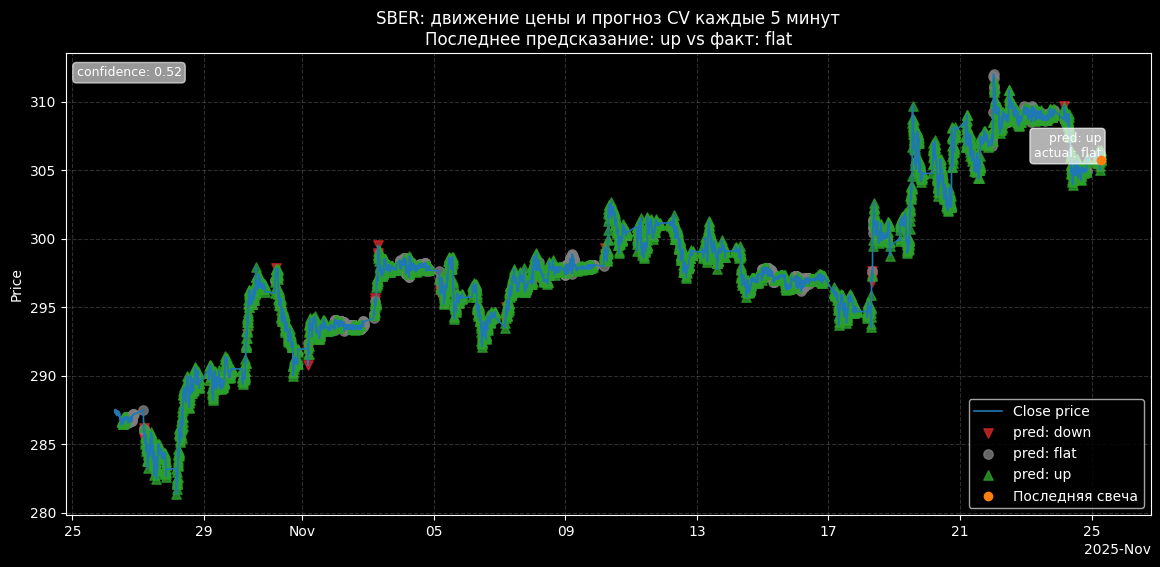

In [12]:
price_df = cv_demo['df_candles'].copy()
price_df['time'] = pd.to_datetime(price_df['time']).dt.tz_convert(TZ)
price_df = price_df.sort_values('time')

pred_df = pd.DataFrame(cv_demo['predictions'])
pred_df['time'] = pd.to_datetime(pred_df['time'])
pred_df = pred_df.sort_values('time')

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(price_df['time'], price_df['close'], label='Close price', color='tab:blue', linewidth=1.2)
ax.set_title(
    f"{TICKER}: движение цены и прогноз CV каждые 5 минут\n"
    f"Последнее предсказание: {cv_demo['summary']['predicted_label']} vs факт: {cv_demo['summary']['actual_label']}"
)
ax.set_ylabel('Price')
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=6, maxticks=12))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True, linestyle='--', alpha=0.3)

pred_points = pred_df.merge(price_df[['time', 'close']], on='time', how='left')
label_colors = {'up': 'tab:green', 'down': 'tab:red', 'flat': 'tab:gray'}
label_markers = {'up': '^', 'down': 'v', 'flat': 'o'}

handles = []
for label, group in pred_points.groupby('predicted_label'):
    scatter = ax.scatter(
        group['time'],
        group['close'],
        color=label_colors.get(label, 'tab:purple'),
        marker=label_markers.get(label, 'o'),
        s=45,
        alpha=0.8,
        label=f"pred: {label}",
    )
    handles.append(scatter)

last_time = price_df['time'].iloc[-1]
last_price = price_df['close'].iloc[-1]
ax.scatter([last_time], [last_price], color='tab:orange', zorder=5, label='Последняя свеча')
ax.text(
    last_time,
    last_price,
    f"pred: {cv_demo['summary']['predicted_label']}\nactual: {cv_demo['summary']['actual_label']}",
    va='bottom',
    ha='right',
    fontsize=9,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
)

if 'predicted_confidence' in cv_demo['summary']:
    ax.annotate(
        f"confidence: {cv_demo['summary']['predicted_confidence']:.2f}",
        xy=(0.01, 0.95),
        xycoords='axes fraction',
        fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
    )

ax.legend()
plt.show()